In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#class representing one simulation.

class Sim:
    def __init__(self, outcome, times, betas, gammas, I, spillover_ids, S):
        
        #0 if extinction, 1 if outbreak, None otherwise. 
        self.outcome = outcome 
        
        #the number of events in the simulation
        self.length = len(times)
        
        #these are all arrays of the same length
        self.times = times #all the times of new events (infections and recoveries, including spillover infections)
        self.betas = betas #the corresponding betas. if the event was a recovery, the corresponding beta is "None"
        self.gammas = gammas #the corresponding gammas. if the event was a recovery, the corresponding gamma is "None"
        self.I = I #the number of infecteds, inclusive of the new event
        self.spillover_ids = spillover_ids #which spillover tree each event belongs to. the spillover trees ids are integers beginning with 0
        self.S = S #the number of susceptibles, inclusive of the new event
        

In [7]:
def recurrent_sim_finite(S_0, alpha, beta_0, gamma_0, mu_1, mu_2, t_thresh = 1000):
    
    t=0
        
    #stuff to fill and return as part of Sim object.
    times = np.array([t])
    all_betas = np.array([beta_0]); all_gammas = np.array([gamma_0])
    all_I = np.array([1]); all_S = np.array([S_0]) #starts with 1 infected
    spillover_ids = np.array([0]) #keep track of which spillover tree each event belongs to
    
    #keep track of how many spillover trees we have seen so far
    spillovers = 0
    
    #initialize variables to keep track of number of susceptible, infected
    S = S_0; I = 1
        
    #initialize variables to keep track of sums of beta, gamma over all currently infected people    
    beta_sum = beta_0; gamma_sum = gamma_0
        
    #initialize matrix of active cases. each case is a row of length 5.
    infecteds=np.array([[beta_0, gamma_0, t, spillovers]])
    
    while True:
        
        #check if we are forced by extinction to stop the simulation
        if alpha == 0 and I == 0:
            #print('extinction')
            return Sim(0, times, all_betas, all_gammas, all_I, spillover_ids, all_S)               
        if S == 0 and I == 0:
            #print('extinction')
            return Sim(0, times, all_betas, all_gammas, all_I, spillover_ids, all_S)
        
        total_pop = S + I #total population 
        
        #grab arrays of all betas gammas deltas
        betas = infecteds[:,0]; gammas = infecteds[:,1]
        
        #adjust betas to actual transmission rates, which depend on proportion of population that is susceptible
        trans_rates = betas*S/total_pop
        
        trans_rates_sum = beta_sum*S/total_pop #sum all transmission rates 
        
        
        #compute interevent time (for the whole population)
        
        #spillover rate depends on alpha and proportion of pop that is susceptible
        spill_rate = alpha*S/total_pop

        #rate of events is alpha + (sum of transmission rate and gamma and delta) over all infected people
        overall_rate = trans_rates_sum + gamma_sum + spill_rate
        
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate)
        t += dt            
        
        #check if we exceeded t_thresh
        if t > t_thresh:
            #print('exceeded t_thresh')
            return Sim(None, times, all_betas, all_gammas, all_I, spillover_ids, all_S)
        
        #figure out whether the event was a new spillover
        event = np.random.rand() #draw from uniform distribution over [0, 1)
        p_spill = spill_rate/overall_rate #probability of spillover
            
        if event < p_spill: #new spillover
            
            #update counters 
            spillovers += 1; I += 1; S -= 1
            
            #append new case to infecteds array
            infecteds = np.append(infecteds, [[beta_0, gamma_0, t, spillovers]], axis=0)

            #update running sums
            beta_sum += beta_0; gamma_sum += gamma_0

            #update return arrays
            times = np.append(times, t)
            all_betas = np.append(all_betas, beta_0); all_gammas = np.append(all_gammas, gamma_0)
            all_I = np.append(all_I, I); all_S = np.append(all_S, S)
            spillover_ids = np.append(spillover_ids, spillovers)

            continue #skip to next event
        
        
        #otherwise, the event was that somebody either transmitted or recovered

        #figure out who the event happened to
        i = np.random.choice(I, p=(trans_rates + gammas)/(overall_rate - spill_rate)) #index of that person
        
        #grab their specific parameters
        beta = betas[i]; gamma = gammas[i]
        trans_rate = beta*S/total_pop #their transmission rate
        spillover_id = infecteds[i][3] #the spillover tree they belong to
        
        #figure out what they did, transmit, recover, or die
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_trans = trans_rate / (trans_rate + gamma) #probability of transmission                
                       
        if (ev < prob_trans): #transmission

            #pick beta, gamma, delta for new case
            #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
            #don't allow negative beta, don't allow negative gamma
            mut1 = np.random.normal(loc=0.0, scale=mu_1); mut2 = np.random.normal(loc=0.0, scale=mu_2)
            new_beta = max(0, beta + mut1); new_gamma = max(0, gamma + mut2)

            #append new case to infecteds array
            infecteds = np.append(infecteds, [[new_beta, new_gamma, t, spillover_id]], axis=0)
                        
            #update counters
            I += 1; S -= 1
            
            #update running sums
            beta_sum += new_beta; gamma_sum += new_gamma
            
            #update return arrays
            times = np.append(times, t)
            all_betas = np.append(all_betas, new_beta); all_gammas = np.append(all_gammas, new_gamma)
            all_I = np.append(all_I, I); all_S = np.append(all_S, S)
            spillover_ids = np.append(spillover_ids, spillover_id)
        
        else: #recovery
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
                        
            #update counters
            I -= 1; S += 1
            
            #update running sums
            beta_sum -= beta; gamma_sum -= gamma
            
            #update return arrays
            times = np.append(times, t)
            all_betas = np.append(all_betas, None); all_gammas = np.append(all_gammas, None)
            all_I = np.append(all_I, I); all_S = np.append(all_S, S)
            spillover_ids = np.append(spillover_ids, spillover_id)

In [ ]:
#color cycles for different spillover trees
def colors(ids):
    dict = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'purple' }
    colors = []
    for id in ids:  
        colors.append(dict[id%6])
    return colors

In [ ]:
#color cycles for different spillover trees
def colors(ids):
    dict = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'purple' }
    colors = []
    for id in ids:  
        colors.append(dict[id%6])
    return colors

outcome =  None


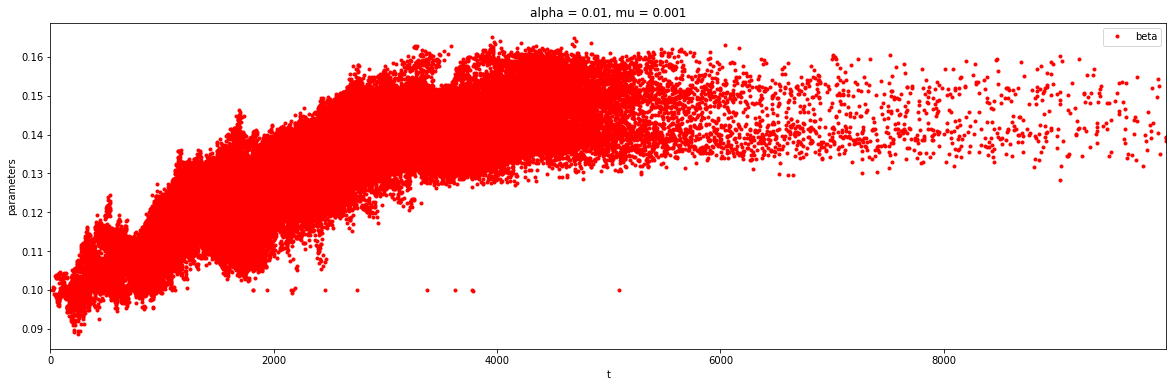

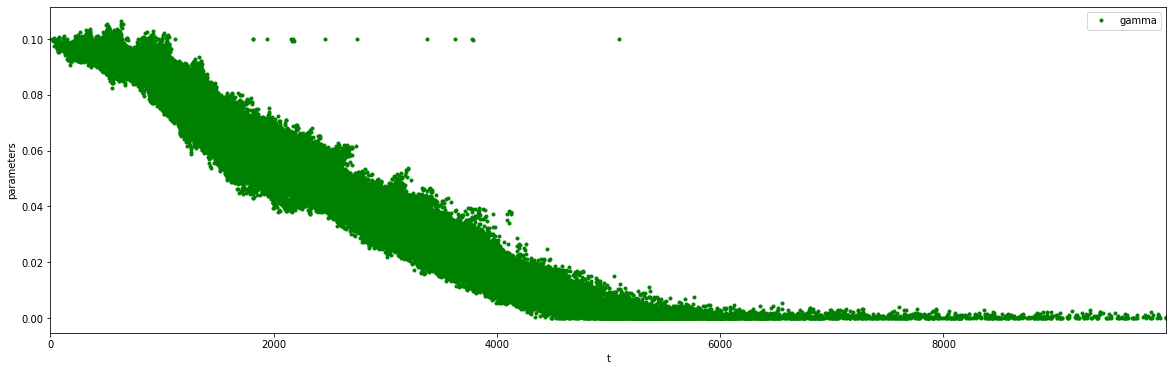

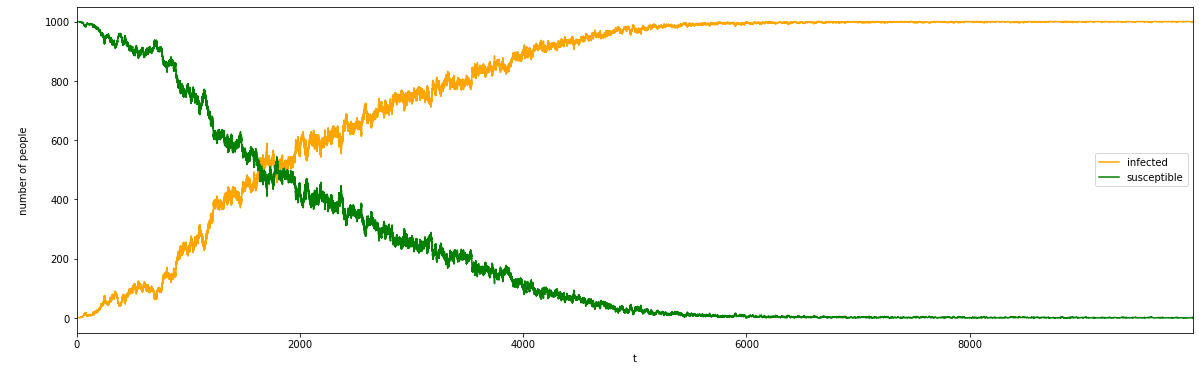

CPU times: user 8min 55s, sys: 32.3 s, total: 9min 27s
Wall time: 9min 52s


In [28]:
%%time

#parameters
S_0 = 1000
beta_0 = 0.1
gamma_0 = 0.1
mu = 0.001
alpha = 0.01

t_thresh = 10000

#compute the simulation

mu_1 = mu; mu_2 = mu

s = recurrent_sim_finite(S_0, alpha, beta_0, gamma_0, mu_1, mu_2, t_thresh)
        
times = s.times; betas = s.betas; gammas = s.gammas; I = s.I; S = s.S; spillover_ids = s.spillover_ids

print('outcome = ', s.outcome)

#plots

############################################ OPTION 1 #########################################################
############# plot each parameter separately, distinguishing between different spillover trees ################

# #plot betas over time
# plt.figure(figsize=(20,6))
# plt.scatter(times, betas, marker = ".", c=colors(spillover_ids), label = 'beta')
# plt.title('alpha = {}, mu = {}'.format(alpha, mu))
# plt.xlabel("t"); plt.ylabel("parameters")
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.legend(); plt.show()

# #plot gammas over time
# plt.figure(figsize=(20,6))
# plt.scatter(times, gammas, marker = ".", c=colors(spillover_ids), label = 'gamma')
# plt.xlabel("t"); plt.ylabel("gamma")
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.show()


############################################ OPTION 2 #########################################################
################################# plot each parameter separately ##############################################
########################### without distinguishing between spillover trees ####################################

#plot betas over time
plt.figure(figsize=(20,6))
plt.plot(times, betas, ".r", label='beta')
plt.title('alpha = {}, mu = {}'.format(alpha, mu_1))
plt.xlabel("t"); plt.ylabel("parameters")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="upper right")
plt.show()

#plot gammas over time
plt.figure(figsize=(20,6))
plt.plot(times, gammas, ".g", label='gamma')
plt.xlabel("t"); plt.ylabel("parameters")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="upper right")
plt.show()


############################################ OPTION 3 #########################################################
################################# plot both parameters together ###############################################
########################### without distinguishing between spillover trees ####################################

# #plot parameters over time
# plt.figure(figsize=(20,6))
# plt.plot(times, betas, ".r", label='beta')
# plt.plot(times, gammas, ".g", label='gamma')
# plt.title('alpha = {}, mu_1 = {}, mu_2 = {}'.format(alpha, mu_1, mu_2))
# plt.xlabel("t"); plt.ylabel("parameters")
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.legend(); plt.show()

###############################################################################################################

#plot infecteds, susceptible over time
plt.figure(figsize=(20,6))
plt.plot(times, I, 'orange', label='infected')
plt.plot(times, S, 'green', label='susceptible')
plt.xlabel("t"); plt.ylabel("\n number of people \n")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="center right")
plt.show()